<a href="https://colab.research.google.com/github/rg-smith/remote-sensing-hydro-2025/blob/main/lectures/lecture8-soil-moisture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 8 - Soil Moisture
In this quick demo, we will extract soil moisture data from SMAP using GEE

First we need to install a couple packages. If this shows an error after running, try the next code block. If it runs without an error, then you should be ok.

In [1]:
pip install geemap pycrs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.9 MB/s eta 0:00:00
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=a12f0d2418b886dc3780f76baa39fb6d1efbae689adba0800295cb506c7bd833
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built pycrs


Now we will clone the git repository, which gives us easy access to the shapefile of the San Juan Mountain HUC8 watershed.

In [2]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from tqdm import tqdm
import zipfile
import os
import pandas as pd
from glob import glob
import geemap
import folium
import branca.colormap as cm

In [3]:
# you only need to run this once per session
ee.Authenticate()
ee.Initialize(project='geocode-1322')

# Define custom functions for working with Google Earth Engine

In [4]:
def add_ee_layer(self, ee_object, name):
    try:
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):
            range = ee.Image(ee_object).reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
            vals = range.getInfo()
            min=list(vals.items())[0][1]
            max=list(vals.items())[1][1]
            vis = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}

            map_id_dict = ee.Image(ee_object).getMapId(vis)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            colormap = cm.LinearColormap(vmin=min,vmax=max,colors=['blue', 'white','red']).to_step(n=10)
            colormap.caption=name
            self.add_child(colormap)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

    except Exception as e:
        print("Could not display {}".format(name))
        print(e)

# Add EE drawing method to folium (not a function)
folium.Map.add_ee_layer = add_ee_layer

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

def gee_zonal_mean_img_coll(imageCollection,geometry,scale=1000):
    reduce_iC = create_reduce_region_function(geometry = geometry, scale=scale)
    stat_fc = ee.FeatureCollection(imageCollection.map(reduce_iC)).filter(ee.Filter.notNull(imageCollection.first().bandNames()))
    fc_dict = fc_to_dict(stat_fc).getInfo()

    df = pd.DataFrame(fc_dict)
    df['date'] = pd.to_datetime(df['millis'],unit='ms')
    return(df)

def gee_zonal_mean(date1,date2,geometry,collection_name,band_name,scale=1000):
     imcol = ee.ImageCollection(collection_name).select(band_name).filterDate(date1,date2)
     df = gee_zonal_mean_img_coll(imcol,geometry,scale=scale)
     return(df)


# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def ee_imgcoll_to_df_point(imagecollection, lat,lon):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    poi = ee.Geometry.Point(lon, lat)
    arr = imagecollection.getRegion(poi,1000).getInfo()

    list_of_bands = imagecollection.first().bandNames().getInfo()

    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

# to get the link to download an earth engine image
def getLink(image,fname,aoi):
  link = image.getDownloadURL({
    'scale': 1000,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi,
    'name': fname})
  # print(link)
  return(link)

# create an earth engine geometry polygon
def addGeometry(min_lon,max_lon,min_lat,max_lat):
  geom = ee.Geometry.Polygon(
      [[[min_lon, max_lat],
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat]]])
  return(geom)

def get_imgcollection(date1,date2,geometry,collection_name,band_name,function='mean'):
  collection = ee.ImageCollection(collection_name)
  if function=='mean':
      img = collection.filterDate(date1,date2).select(band_name).mean().clip(geometry)
  if function=='sum':
      img = collection.filterDate(date1,date2).select(band_name).sum().clip(geometry)
 # range = img.reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
 # vals = range.getInfo()
 # min=list(vals.items())[0][1]
 # max=list(vals.items())[1][1]
 # visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(img)

def download_img(img,geom,fname):
    linkname = getLink(img,fname,geom)
    response = requests.get(linkname, stream=True)
    zipped = fname+'.zip'
    with open(zipped, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    with zipfile.ZipFile(zipped, 'r') as zip_ref:
        zip_ref.extractall('')
    os.remove(zipped)


def aggregate_by_water_year(df,date_col,agg_column,agg_fun='sum'):
    df['water_year'] = df[date_col].dt.year.where(df[date_col].dt.month < 10, df[date_col].dt.year + 1)
    df_agg = df.groupby('water_year').agg({agg_column:[agg_fun]})
    return(df_agg)

# Part 1: Gather and plot soil moisture and precip data

In [63]:
start='2023-04-01'
end='2023-09-30'

geom = addGeometry(-105.9,-105.3,40.26,40.7)

In [60]:
my_map = folium.Map(location=[40.5, -105.7], zoom_start=9)
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(my_map)

my_map.add_ee_layer(geom,'geom')

my_map.add_child(folium.LayerControl())
display(my_map)

In [64]:
# take the spatial mean to get area-averaged time series over first area.

gridmet_ppt = gee_zonal_mean(start,end,geom,'IDAHO_EPSCOR/GRIDMET','pr',scale=10000)
gridmet_eto = gee_zonal_mean(start,end,geom,'IDAHO_EPSCOR/GRIDMET','eto',scale=10000)
soil_moisture_df = gee_zonal_mean(start,end,geom,'NASA/SMAP/SPL3SMP_E/006','soil_moisture_am',scale=10000)

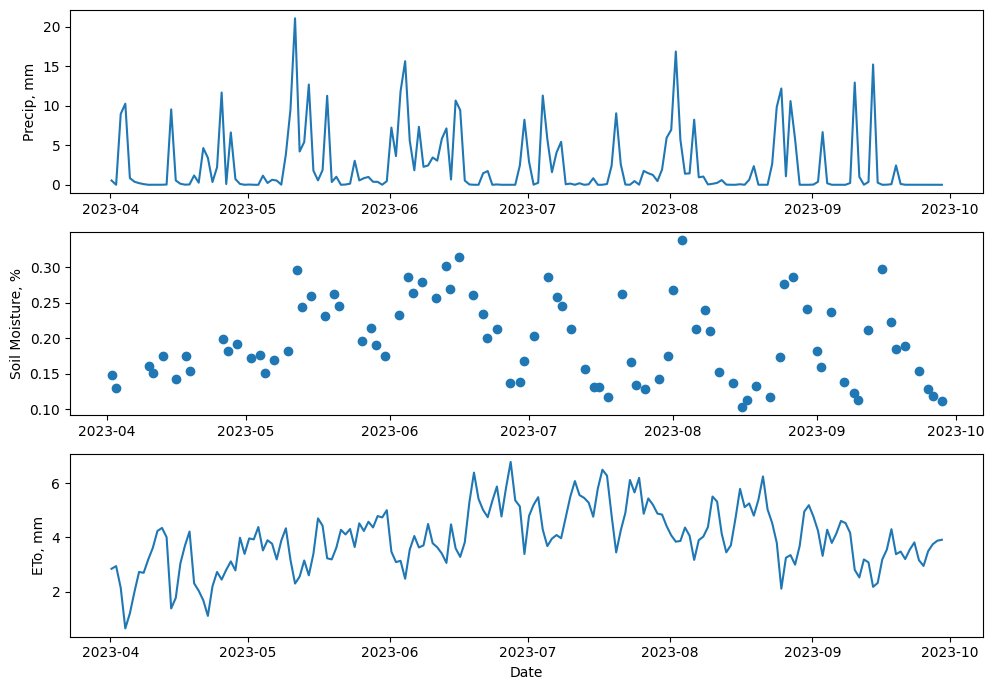

In [65]:
# plot and compare both regions

plt.figure(figsize=(10,7));plt.subplot(3,1,1)
plt.plot(gridmet_ppt['date'],gridmet_ppt['pr'])
plt.ylabel('Precip, mm')
plt.subplot(3,1,2)
plt.plot(soil_moisture_df['date'],soil_moisture_df['soil_moisture_am'],'o')
plt.ylabel('Soil Moisture, %')
plt.subplot(3,1,3)
plt.plot(gridmet_eto['date'],gridmet_eto['eto'])
plt.ylabel('ETo, mm')
plt.xlabel('Date')
plt.tight_layout()